## MNIST Image Classification with an RNN Model

### Build the dataset and dataloader

In [1]:
import torch
import torchvision
from torchvision import transforms

# Define the transformations to apply to the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load MNIST data from assets/MNIST
train_dataset = torchvision.datasets.MNIST(root='./assets', train=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./assets', train=False, transform=transform)

# Create the data loaders
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


### Visualize samples from the dataset

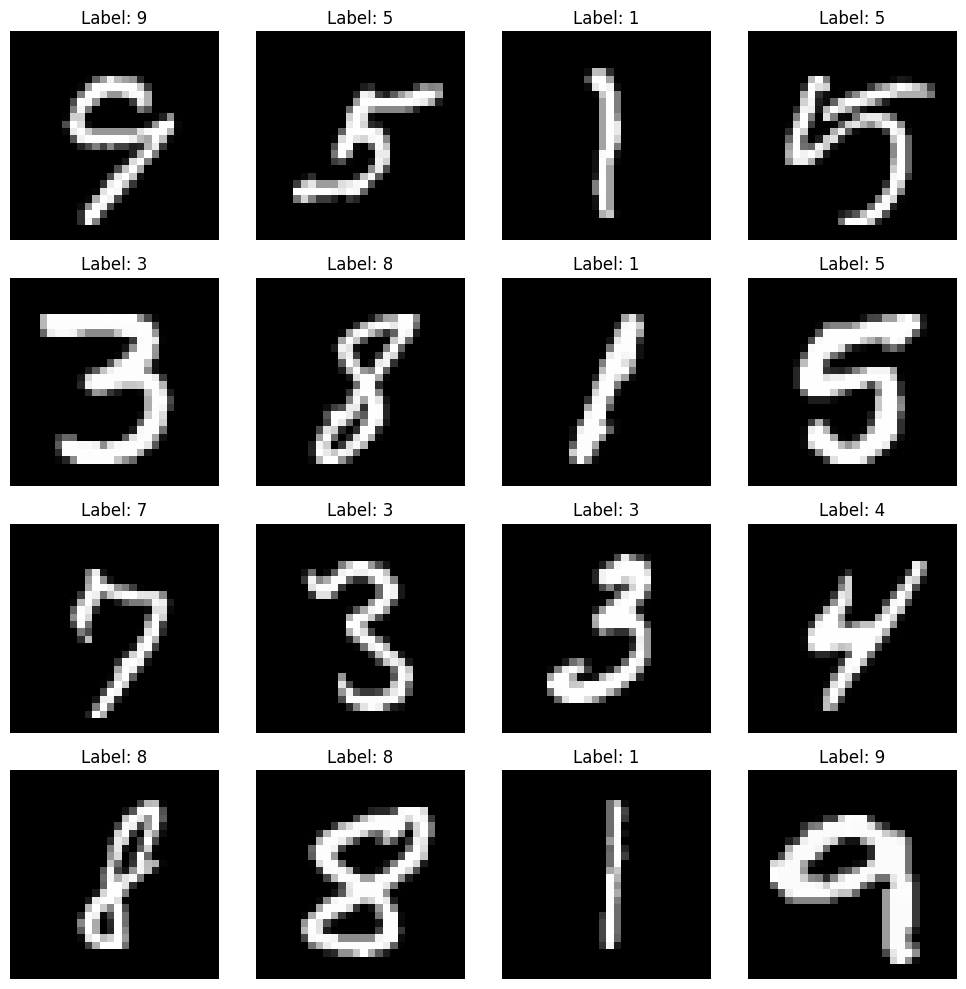

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Get 16 random indices
indices = np.random.choice(len(train_dataset), size=16, replace=False)

# Get the corresponding images and labels
images = [train_dataset[i][0] for i in indices]
labels = [train_dataset[i][1] for i in indices]

# Create a figure with 4x4 subplots
fig, axes = plt.subplots(4, 4, figsize=(10, 10))

# Iterate over the subplots and display the images with labels
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i].squeeze(), cmap='gray')
    ax.set_title(f"Label: {labels[i]}")
    ax.axis('off')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the figure
plt.show()


### Build the RNN Model

In [2]:
import torch
import torch.nn as nn
from einops import rearrange, repeat, reduce
from torch import einsum

def fc_eins(input_size, output_size):
    W = nn.Parameter(torch.randn(input_size, output_size) * 0.01)  # Weight initialization
    b = nn.Parameter(torch.zeros(output_size))                     # Bias initialization

    def fc_linear(x):
      return torch.einsum('ij,jk->ik', x, W) + b
    return fc_linear, W, b

# Build an RNN model to classsify MNIST images
class RNN(nn.Module):
    def __init__(self, input_size=28, hidden_size=256, num_layers=1, num_classes=10):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc_eins, self.W, self.b = fc_eins(hidden_size, num_classes)

    def forward(self, x):
        # input is a "sequence" of 28 features w/ length 28
        
        # use einops to remove second dimension of x
        x = reduce(x, 'b c h w -> b h w', 'mean')
        y, _ = self.rnn(x) #, h0)

        # retrieve the last element of the sequence using einops

        y = self.fc_eins(y[:, -1, :])
        return y


x = torch.randn(64, 1, 28, 28)
model = RNN()
print(model)
print(model(x).shape)

# print the number of parameters
num_params = sum(p.numel() for p in model.parameters())
# Use comma to print the number in a more readable format
print(f"Number of parameters: {num_params:,}")

SyntaxError: invalid syntax (2881979888.py, line 25)

In [4]:
from einops import rearrange, repeat, reduce
from torch import einsum

# sample x tensor
x = torch.randn(64, 1, 28, 28)

# use einops to remove second dimension of x
x1 = reduce(x, 'b c h w -> b h w', 'mean')
x2 = rearrange(x, 'b c h w -> b (c h) w')

# compare x1 and x2
print(x1.shape)
print(x2.shape)

# is x1 == x2?
print(torch.allclose(x1, x2))

torch.Size([64, 28, 28])
torch.Size([64, 28, 28])
True


### Define the loss function and optimizer

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### Train the model

In [6]:
from tqdm import tqdm

num_epochs = 10

model.train()
for epoch in tqdm(range(num_epochs)):
    total_loss = 0
    
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
    
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch: {epoch+1}, Loss: {avg_loss:.4f}")


 10%|█         | 1/10 [00:08<01:13,  8.13s/it]

Epoch: 1, Loss: 0.5937


 20%|██        | 2/10 [00:16<01:07,  8.48s/it]

Epoch: 2, Loss: 0.2645


 30%|███       | 3/10 [00:25<01:00,  8.70s/it]

Epoch: 3, Loss: 0.2023


 40%|████      | 4/10 [00:34<00:52,  8.81s/it]

Epoch: 4, Loss: 0.1650


 50%|█████     | 5/10 [00:43<00:43,  8.79s/it]

Epoch: 5, Loss: 0.1542


 60%|██████    | 6/10 [00:52<00:34,  8.73s/it]

Epoch: 6, Loss: 0.1449


 70%|███████   | 7/10 [01:00<00:26,  8.76s/it]

Epoch: 7, Loss: 0.1302


 80%|████████  | 8/10 [01:09<00:17,  8.82s/it]

Epoch: 8, Loss: 0.1315


 90%|█████████ | 9/10 [01:19<00:08,  8.91s/it]

Epoch: 9, Loss: 0.1220


100%|██████████| 10/10 [01:28<00:00,  8.83s/it]

Epoch: 10, Loss: 0.1192


### Evaluate the model

In [ ]:
model.eval()  # Set the model to evaluation mode

correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Test Accuracy: {accuracy:.4f}")


### Predict on sample images

In [ ]:
import random

# Set the model to evaluation mode
model.eval()

# Select a random image from the test dataset
random_index = random.randint(0, len(test_dataset) - 1)
image, label = test_dataset[random_index]

# Move the image to the device
image = image.to(device)

# Forward pass to get the predicted label
output = model(image.unsqueeze(0))
_, predicted_label = torch.max(output, 1)

# Convert the image tensor to a numpy array
image_np = image.cpu().numpy()

# Display the image, its label, and the predicted label
plt.imshow(image_np.squeeze(), cmap='gray')
plt.title(f"Label: {label}, Predicted: {predicted_label.item()}")
plt.axis('off')
plt.show()
